# Fragentypen analysieren

In [ ]:
import re
import pandas as pd
from pathlib import Path
from datasets import load_from_disk
import matplotlib.pyplot as plt
from hashlib import md5
import numpy as np

In [15]:
def get_question_type(question):
    """
    Bestimmt den Fragetyp anhand des ersten Wortes der Frage.
    - Wenn das erste Wort ein typisches Fragewort (z. B. What, Where, When, How, Why, Who, Whom, Which) ist,
      wird genau dieses (capitalized) zurückgegeben.
    - Wenn das erste Wort ein Hilfsverb ist (z. B. is, are, do, etc.), wird "Yes/No" zurückgegeben.
    - Andernfalls wird "Other" zurückgegeben.
    """
    q = question.strip().lower()
    match = re.match(r"(\w+)", q)
    if match:
        first_word = match.group(1)
        interrogatives = {"what", "where", "when", "how", "why", "who", "whom", "which"}
        if first_word in interrogatives:
            return first_word.capitalize()
        auxiliaries = {"is", "are", "do", "does", "did", "can", "could", "would", "will", "have", "has", "had", "am"}
        if first_word in auxiliaries:
            return "Yes/No"
        return "Other"
    else:
        return "Unknown"

# Definiere die Pfade zu den Datensätzen
project_root = Path.cwd().parent
data_path_train = project_root / "data" / "train"
data_path_validation = project_root / "data" / "validation"
data_path_test = project_root / "data" / "test"

dataset_train = load_from_disk(str(data_path_train))
dataset_val = load_from_disk(str(data_path_validation))
dataset_test = load_from_disk(str(data_path_test))

df_train = dataset_train.to_pandas()
df_val = dataset_val.to_pandas()
df_test = dataset_test.to_pandas()

# zusammenführen für den ganzen Datensatz
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Bestimme den Fragetyp für jede Frage
df_all["question_type"] = df_all["question"].apply(get_question_type)

# Gruppiere nach Fragetyp und berechne Anzahl und prozentualen Anteil
summary = df_all.groupby("question_type")["question"].agg(["count"]).reset_index()
total = summary["count"].sum()
summary["percentage"] = (summary["count"] / total * 100).round(1)
summary = summary.sort_values("count", ascending=False)

print("Fragetypen im gesamten Datensatz:")
print(summary)


Fragetypen im gesamten Datensatz:
  question_type  count  percentage
7        Yes/No  16194        49.6
2          What  13337        40.9
4         Where   2155         6.6
0           How    695         2.1
6           Why    114         0.3
1         Other     86         0.3
3          When     49         0.2
5           Who      2         0.0


# Neuer Val Datensatz mit 2000 Einträgen

In [20]:
#ähnliche Funktion wie oben 
def get_question_type(question):
    q = question.strip().lower()
    if q.startswith("what"):
        return "What"
    elif q.startswith("where"):
        return "Where"
    elif q.startswith("when"):
        return "When"
    elif q.startswith("how much") or q.startswith("how many"):
        return "How much/How many"
    elif q.startswith("how"):
        return "How"
    elif q.startswith("why"):
        return "Why"
    elif q.startswith("who"):
        return "Who"
    yes_no_words = ("is", "are", "do", "does", "did", "can", "could", "would", "will", "have", "has", "had", "am")
    if q.startswith(yes_no_words):
        return "Yes/No"
    return "Other"

# Nur für den Validierungsdatensatz jetzt auswerten
dataset = load_from_disk(str(data_path_validation))
df_val = dataset.to_pandas()

if "question_type" not in df_val.columns:
    df_val["question_type"] = df_val["question"].apply(get_question_type)

# Verteilung aus Analyse von vorhin
distribution = {
    "Yes/No": 49.6,
    "What": 40.9,
    "Where": 6.6,
    "How": 2.1,
    "Why": 0.3,
    "Other": 0.3,
    "When": 0.2,
    "Who": 0.0
}

total_new = 2000

#Anzahl wieviele gemacht werden müssen
desired_counts = {typ: int(round(total_new * perc / 100)) for typ, perc in distribution.items()}
print("Gewünschte Anzahl pro Fragetyp:")
for typ, count in desired_counts.items():
    print(f"{typ}: {count}")

# Stratifiziertes Sampling pro Fragetyp
samples = []
for typ, desired in desired_counts.items():
    group = df_val[df_val["question_type"] == typ]
    if desired > 0:
        if len(group) >= desired:
            sampled = group.sample(n=desired, random_state=42)
        else:
            print(f"Warnung: Gruppe '{typ}' hat nur {len(group)} Einträge. Verwende alle Einträge.")
            sampled = group
        samples.append(sampled)

# Zusammenführen und mischen da viele Bilder hintereinander kommen im Validierungsdatensatz
new_df = pd.concat(samples).sample(frac=1, random_state=42).reset_index(drop=False)
print(f"\nNeuer Datensatz hat {len(new_df)} Einträge.")

new_distribution = new_df["question_type"].value_counts(normalize=True) * 100
print("\nVerteilung im neuen Datensatz (in %):")
print(new_distribution.sort_index())


Gewünschte Anzahl pro Fragetyp:
Yes/No: 992
What: 818
Where: 132
How: 42
Why: 6
Other: 6
When: 4
Who: 0

Neuer Datensatz hat 2000 Einträge.

Verteilung im neuen Datensatz (in %):
question_type
How        2.1
Other      0.3
What      40.9
When       0.2
Where      6.6
Why        0.3
Yes/No    49.6
Name: proportion, dtype: float64

Neuer Datensatz wurde unter C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\data\validation_subset_2000.csv gespeichert.


In [21]:
len(new_df)

2000

In [22]:
selected_indices = new_df["index"].tolist()

output_indices_file = project_root / "data" / "validation_subset_indices.txt"
with open(output_indices_file, "w", encoding="utf-8") as f:
    for idx in selected_indices:
        f.write(str(idx) + "\n")
print(f"\nDie ausgewählten Indizes wurden unter '{output_indices_file}' gespeichert.")


Die ausgewählten Indizes wurden unter 'C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\data\validation_subset_indices.txt' gespeichert.


In [28]:
selected_indices

[921,
 4681,
 662,
 5810,
 6182,
 1938,
 4280,
 2759,
 6098,
 4728,
 3405,
 2828,
 1473,
 5263,
 1012,
 1306,
 2602,
 3268,
 3550,
 5771,
 3679,
 3657,
 2857,
 1794,
 351,
 3632,
 581,
 1318,
 5545,
 3384,
 6253,
 2134,
 5734,
 4006,
 1217,
 3929,
 415,
 563,
 100,
 4549,
 2797,
 5844,
 3606,
 57,
 6070,
 137,
 881,
 3662,
 3766,
 5660,
 3380,
 1746,
 5286,
 554,
 4925,
 4507,
 5970,
 1832,
 4579,
 3458,
 116,
 1393,
 697,
 3167,
 1412,
 5325,
 3381,
 1749,
 123,
 2876,
 3553,
 2268,
 5524,
 3702,
 895,
 744,
 3299,
 2735,
 6185,
 4670,
 2832,
 4241,
 264,
 4461,
 3493,
 154,
 3614,
 519,
 3564,
 2417,
 2479,
 1176,
 379,
 6238,
 2840,
 948,
 2394,
 4075,
 5468,
 781,
 736,
 3974,
 4100,
 1342,
 2414,
 2861,
 1168,
 5998,
 2032,
 6114,
 2438,
 2722,
 2348,
 4193,
 3032,
 3138,
 1220,
 4003,
 6081,
 5262,
 1139,
 468,
 4319,
 4256,
 3343,
 4109,
 3507,
 346,
 2331,
 2533,
 5673,
 974,
 6257,
 3189,
 2314,
 2180,
 1747,
 2555,
 1810,
 2374,
 4010,
 3174,
 4005,
 3366,
 4453,
 1288,
 1731

In [29]:
# Sind alle im erlaubten Bereich
print("Max Index in selected_indices:", max(selected_indices))
print("Dataset size:", len(dataset))


Max Index in selected_indices: 6258
Dataset size: 6259


In [30]:
filtered_val_dataset = dataset.select(selected_indices)

print("Anzahl der ausgewählten Einträge:", len(filtered_val_dataset))
print(filtered_val_dataset)


Anzahl der ausgewählten Einträge: 2000
Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 2000
})


In [31]:
filtered_val_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=792x523>,
 'question': 'where does this belong to?',
 'answer': 'endocrine system'}

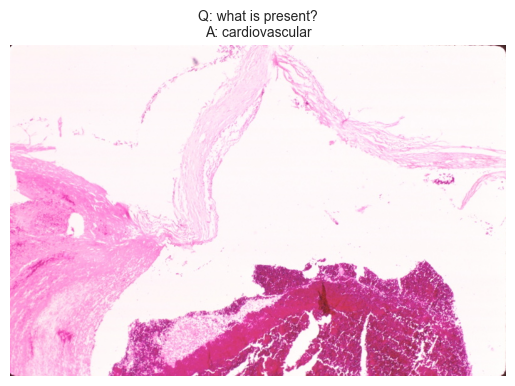

In [35]:
sample = filtered_val_dataset[2] 
image = sample["image"] 
question = sample["question"]
answer = sample["answer"]

plt.imshow(image)
plt.axis("off") 
plt.title(f"Q: {question}\nA: {answer}", fontsize=10)
plt.show()

In [36]:
#Prüfen wieviel Bildduplikate wir haben, da es nicht zuviele sein dürfen

def image_to_hash(image):
    img_array = np.array(image)
    img_bytes = img_array.tobytes()
    return md5(img_bytes).hexdigest()

hash_counts = {}
for sample in filtered_val_dataset:
    h = image_to_hash(sample["image"])
    hash_counts[h] = hash_counts.get(h, 0) + 1

# Filtere nur doppelte und sortiere sie absteigend nach Häufigkeit
duplicates = {k: v for k, v in hash_counts.items() if v > 1}
sorted_duplicates = sorted(duplicates.items(), key=lambda x: x[1], reverse=True)

print(f"Anzahl doppelter Bilder: {len(duplicates)}")
print("Top 5 doppelte Bilder (Hash → Vorkommen):")
for h, count in sorted_duplicates[:50]:
    print(f"{h} → {count}x")


C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Anzahl doppelter Bilder: 538
Top 5 doppelte Bilder (Hash → Vorkommen):
0de1ba1702db9367f66004ebfe7dc8a0 → 12x
cff9167c74756578a96736da83ac3caf → 12x
e6416a7a6e33321183d6bdbd506a99e3 → 11x
bebc3a085d642b5329659cfde7493a8a → 10x
ddd962009981b3c06e1dbc8abc90f08c → 9x
fe8842649783bfa611df5c102b49ef81 → 9x
27fcded16290fef3f1ae49a5d5ad62a4 → 9x
c7ce99f3fefce4ea6e8a33bea8cc3793 → 9x
9a8face4e2186cb43066e227debfc085 → 9x
ffca083fa03c543ade2bf24e561ff525 → 8x
8328aaba170a567ce1d982c90da7b19f → 8x
dc4beaf2c405f8002830d832044ced6a → 8x
9f4be6be36784efeefe96f9b3cbf12d4 → 7x
eb172866bafc8f22c9f5b2672cae5fbb → 7x
b64cec0e1018f81713b373eae9bf25c6 → 7x
e25be99cdf45fe42eb01bd84d30ae43d → 7x
33ee59b2984cbd7e47a4cd2b52d38325 → 7x
acc5f5c929572cb729daccb46830d2b3 → 7x
3429127b8eb6440a6b435f06fb96994c → 7x
bbdba1ae0d54eb6e28ace75c58f6ca88 → 7x
1e577624ea00c60ebe76734329297872 → 7x
f0fad93bd54943826878d88d2de1412c → 7x
6b763d0b9eabaa81f834a815e2cc0e8e → 7x
55910adaf865b0410262061bd563f2ca → 7x
7b071aee85175